# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.models import resnet18

from torchsummary import summary
from tqdm import tqdm

In [4]:
from Modules.data import cifiar_data_loader
from Modules.models.resnet import ResNet18 as Net

#from Modules.models.torchvision_resnet import Net

from Modules.train.train_eval import train, test
from Modules.utility import visulization
from Modules.grad_cam.gradcam import GradCAM, GradCAMpp
from Modules.grad_cam.utility import visualize_cam

In [5]:
#Net = resnet18

# Data loader

In [6]:
my_args = {'pin_memory' : False, 'num_workers': 1}
train_loader, test_loader = cifiar_data_loader.get_dataloder(args=my_args)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Visualization

In [7]:
it = iter(train_loader)

In [8]:
images, labels = it.next()

In [9]:
idx_to_class = {train_loader.dataset.class_to_idx[x] : x for x in train_loader.dataset.class_to_idx}

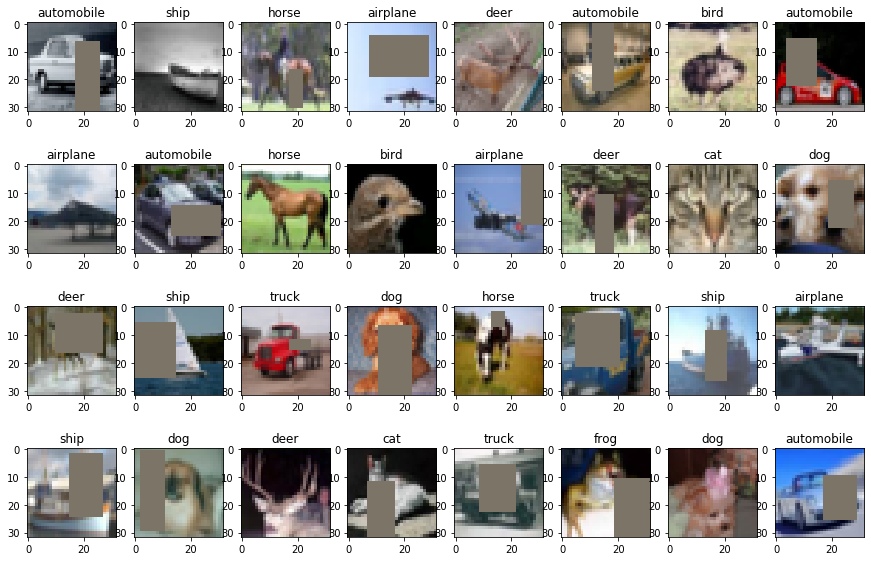

In [10]:
visulization.display_images(images, labels, idx_to_class)

# Network

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

# Train Phase

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

In [13]:
for param in model.parameters():
    print(param.requires_grad)
    #param.requires_grad = True

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [14]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

total_epochs = 1
for i in range(total_epochs):
    train(model, device, train_loader, optimizer, i, train_losses, train_acc)
    test(model, device, test_loader,  test_losses, test_acc)

0 loss : 1.203885793685913 acc : 0.5: 100%|██████████| 1563/1563 [00:45<00:00, 32.91it/s]     


Acc :  63.83


In [ ]:
visulization.display_graphs(train_losses, test_losses, train_acc, test_acc)

# GradCam

In [ ]:
gradcam  = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer4')
#gradcam_pp = GradCAMpp.from_config(model_type='resnet', arch=model, layer_name='layer4')

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

In [ ]:
def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean)

for i in range(8):
        
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    input_img = images[i]
    input_img = np.expand_dims(input_img, 0)
    input_img = torch.tensor(input_img)
    input_img = input_img.to(device)

    mask, _ = gradcam(input_img)
    input_img = denormalize(input_img, mean, std)

    heatmap, result = visualize_cam(mask, input_img)
    
    fig, ax = plt.subplots(1, 2)
    tmp_img = np.array(heatmap)
    tmp_img = tmp_img.transpose([1, 2, 0])
    ax[0].imshow(tmp_img)
    
    tmp_img = np.array(result)
    tmp_img = tmp_img.transpose([1, 2, 0])
    ax[1].imshow(tmp_img)
    plt.show()